In [23]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow import keras
import numpy as np
import json
import math
import inspect
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
def get_color_labels_dict():
    return {
        "bad": 0,
        "good": 1,
    }

target_names = np.array(list(get_color_labels_dict().keys()))

def get_target_name(index):
    return target_names[index]

def encode_color_labels_as_int(labels):
    labels_dict = get_color_labels_dict()
    breakpoint()
    return list(map(lambda label: labels_dict[label], labels))

def get_rgb_values(color):
    rgb_array = [color['red'], color['green'], color['blue']]
    return rgb_array

def get_color_label(color):
    return color["label"]

def load_json():
    path = "../data/labeled-colors-1015.json"

    with open(path) as json_file:
        json_str = json_file.read()

    return json.loads(json_str)

def prep_data(data):
    rgb_list = list(map(get_rgb_values, data))
    labels_as_int = list(map(get_color_label, data))
#     labels_as_int = encode_color_labels_as_int(labels_as_string)
    
    rgb_ndarray = np.array(rgb_list)
    labels_ndarray = np.array(labels_as_int)
    
    return (rgb_ndarray, labels_ndarray)

def load_data():
    colors_array = load_json()
    prepped_data = prep_data(colors_array)
    return prepped_data

# Plot a grid of individual colors from the dataset
# The colors won’t be labeled
# I tried using annotate to label the colors, but positioning the labels was tedious
def plot_colors(one_hundred_colors):
    plt.figure(figsize=(12, 12), facecolor="black", tight_layout=True)
    # We reshape the colors into a square, so we need to know the size of the passed argument ahead of time...
    # That’s why it’s called one_hundred_colors
    plt.imshow(one_hundred_colors.reshape(10, 10, 3))
    plt.axis("off")
    plt.annotate('Test', xy=(0.9, 0.0), xycoords="axes fraction")
    
# Plot a bunch of colors from the dataset, and their labels
def plot_train_data(X, y, start=0, count=24):
    max_count = min(count, X.shape[0])
    
    n_cols = 8
    n_rows = math.ceil(max_count / n_cols)
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            
            # Stop plotting if you reached the desired count
            if (index == max_count):
                return
            
            plt.subplot(n_rows, n_cols, index + 1)
            
#             breakpoint()
            data_index = start + index
            
            color = X[data_index, :]
            color = color[np.newaxis, :]
            
            # You need this reshaping to get a 1x1 image with 3 channels
            # Otherwise you’d get 3 pixels side by side
            color = color.reshape(1, 1, 3)
            
            target_name = get_target_name(y[data_index])
            
            plt.imshow(color)
            plt.axis('off')
            plt.title(target_name, fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()
    
def shuffle(array):
    rng = np.random.default_rng()
    array_copy = array.copy()
    return rng.shuffle(array_copy)

def split_train_test_valid(data, test_size=0.3, valid_size=0.1):
    total_count = data.shape[0]
    
    test_count = math.floor(total_count * test_size)
    valid_count = math.floor(total_count * valid_size)
    train_count = total_count - test_count - valid_count
    
    train = data[:train_count, :]
    
    valid_start_index = train_count
    valid_end_index = valid_start_index + valid_count
    valid = data[valid_start_index:valid_end_index, :]
    
    test_start_index = valid_end_index
    test = data[test_start_index:, :]
    
    return (train, valid, test)

In [25]:
X, y = load_data()

np.save("../data/data_X", X, allow_pickle=True)
np.save("../data/data_y", y, allow_pickle=True)

X_train, X_valid, X_test = split_train_test_valid(X)
y_train, y_valid, y_test = split_train_test_valid(y[:, np.newaxis])
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(610, 3) (101, 3) (304, 3)
(610, 1) (101, 1) (304, 1)


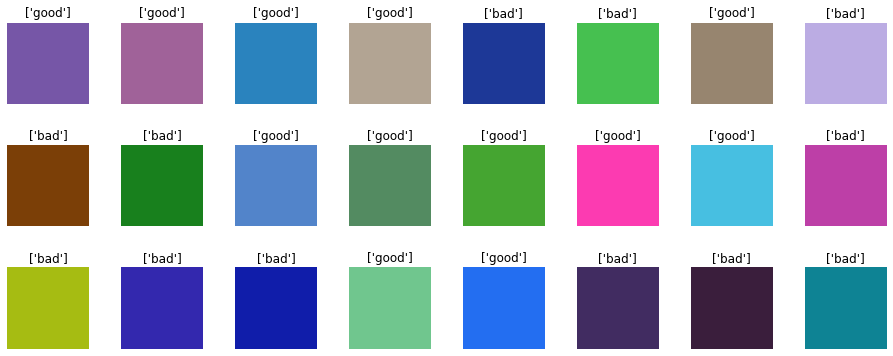

In [26]:
plot_train_data(X_valid, y_valid, start=0)

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu", input_shape=[3]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 31,502
Trainable params: 31,502
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_valid, y_valid))

Epoch 1/300
20/20 [==============================] - 0s 6ms/step - loss: 17.5806 - accuracy: 0.6689 - val_loss: 1.2229 - val_accuracy: 0.5743
Epoch 2/300
20/20 [==============================] - 0s 2ms/step - loss: 0.5678 - accuracy: 0.7279 - val_loss: 1.4306 - val_accuracy: 0.5842
Epoch 3/300
20/20 [==============================] - 0s 2ms/step - loss: 0.7503 - accuracy: 0.7000 - val_loss: 2.7371 - val_accuracy: 0.5347
Epoch 4/300
20/20 [==============================] - 0s 2ms/step - loss: 0.6517 - accuracy: 0.6869 - val_loss: 0.5390 - val_accuracy: 0.7030
Epoch 5/300
20/20 [==============================] - 0s 2ms/step - loss: 0.5201 - accuracy: 0.7311 - val_loss: 0.5645 - val_accuracy: 0.6436
Epoch 6/300
20/20 [==============================] - 0s 2ms/step - loss: 0.5307 - accuracy: 0.7279 - val_loss: 0.6593 - val_accuracy: 0.6139
Epoch 7/300
20/20 [==============================] - 0s 2ms/step - loss: 0.5026 - accuracy: 0.7311 - val_loss: 1.4797 - val_accuracy: 0.5347
Epoch 8/300


Epoch 59/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4736 - accuracy: 0.7705 - val_loss: 0.6018 - val_accuracy: 0.7030
Epoch 60/300
20/20 [==============================] - 0s 2ms/step - loss: 0.5041 - accuracy: 0.7590 - val_loss: 0.7405 - val_accuracy: 0.6337
Epoch 61/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4913 - accuracy: 0.7607 - val_loss: 0.6094 - val_accuracy: 0.7129
Epoch 62/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4902 - accuracy: 0.7607 - val_loss: 0.9565 - val_accuracy: 0.6139
Epoch 63/300
20/20 [==============================] - 0s 2ms/step - loss: 0.5188 - accuracy: 0.7541 - val_loss: 0.5697 - val_accuracy: 0.6832
Epoch 64/300
20/20 [==============================] - 0s 2ms/step - loss: 0.5011 - accuracy: 0.7525 - val_loss: 0.5400 - val_accuracy: 0.7129
Epoch 65/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4858 - accuracy: 0.7574 - val_loss: 0.5400 - val_accuracy: 0.7129
Epoch 

20/20 [==============================] - 0s 2ms/step - loss: 0.4680 - accuracy: 0.7689 - val_loss: 0.4785 - val_accuracy: 0.7525
Epoch 117/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4743 - accuracy: 0.7639 - val_loss: 0.5480 - val_accuracy: 0.6733
Epoch 118/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4782 - accuracy: 0.7754 - val_loss: 0.6389 - val_accuracy: 0.6634
Epoch 119/300
20/20 [==============================] - 0s 2ms/step - loss: 0.5050 - accuracy: 0.7607 - val_loss: 0.6067 - val_accuracy: 0.6733
Epoch 120/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4746 - accuracy: 0.7721 - val_loss: 0.5043 - val_accuracy: 0.7723
Epoch 121/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4731 - accuracy: 0.7721 - val_loss: 0.4476 - val_accuracy: 0.8119
Epoch 122/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4700 - accuracy: 0.7902 - val_loss: 0.5165 - val_accuracy: 0.7327
Epoch 123/300

20/20 [==============================] - 0s 2ms/step - loss: 0.4536 - accuracy: 0.7967 - val_loss: 0.6333 - val_accuracy: 0.7129
Epoch 174/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.7885 - val_loss: 0.5429 - val_accuracy: 0.7624
Epoch 175/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4621 - accuracy: 0.7770 - val_loss: 0.7636 - val_accuracy: 0.5941
Epoch 176/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4966 - accuracy: 0.7672 - val_loss: 0.6053 - val_accuracy: 0.7327
Epoch 177/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4533 - accuracy: 0.7705 - val_loss: 0.5693 - val_accuracy: 0.7030
Epoch 178/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4449 - accuracy: 0.7967 - val_loss: 0.4690 - val_accuracy: 0.8119
Epoch 179/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4379 - accuracy: 0.7934 - val_loss: 0.4961 - val_accuracy: 0.8020
Epoch 180/300

20/20 [==============================] - 0s 2ms/step - loss: 0.4610 - accuracy: 0.7836 - val_loss: 0.4858 - val_accuracy: 0.7723
Epoch 231/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4539 - accuracy: 0.7984 - val_loss: 0.6293 - val_accuracy: 0.6139
Epoch 232/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4660 - accuracy: 0.7738 - val_loss: 1.6253 - val_accuracy: 0.5743
Epoch 233/300
20/20 [==============================] - 0s 2ms/step - loss: 0.5537 - accuracy: 0.7607 - val_loss: 0.6192 - val_accuracy: 0.7327
Epoch 234/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4921 - accuracy: 0.7705 - val_loss: 0.5739 - val_accuracy: 0.7327
Epoch 235/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4687 - accuracy: 0.7803 - val_loss: 0.5345 - val_accuracy: 0.7228
Epoch 236/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4691 - accuracy: 0.7738 - val_loss: 0.5166 - val_accuracy: 0.7525
Epoch 237/300

20/20 [==============================] - 0s 2ms/step - loss: 0.4368 - accuracy: 0.7803 - val_loss: 0.4722 - val_accuracy: 0.7822
Epoch 288/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.7918 - val_loss: 0.6202 - val_accuracy: 0.6931
Epoch 289/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4651 - accuracy: 0.7721 - val_loss: 0.4487 - val_accuracy: 0.8218
Epoch 290/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4385 - accuracy: 0.7885 - val_loss: 0.4911 - val_accuracy: 0.7723
Epoch 291/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4408 - accuracy: 0.7902 - val_loss: 0.5467 - val_accuracy: 0.7921
Epoch 292/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4491 - accuracy: 0.7934 - val_loss: 0.5566 - val_accuracy: 0.7129
Epoch 293/300
20/20 [==============================] - 0s 2ms/step - loss: 0.4418 - accuracy: 0.7787 - val_loss: 0.9214 - val_accuracy: 0.6238
Epoch 294/300

In [30]:
# Check loss and accuracy on test dataset
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 810us/step - loss: 0.5188 - accuracy: 0.7336


[0.5187554359436035, 0.7335526347160339]

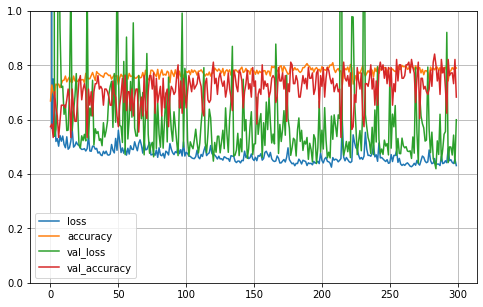

In [31]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [32]:
# Each prediction is an array of 9 probabilities, which all add up to 1
X_new = X_test[:5]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.61, 0.39],
       [0.83, 0.17],
       [0.79, 0.21],
       [0.95, 0.05],
       [0.05, 0.95]], dtype=float32)

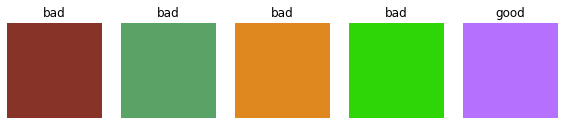

In [33]:
y_indexes = np.argmax(y_proba, axis=1)
plot_train_data(X_new, y_indexes, start=0, count=30)

In [34]:
# Save model
# You can ignore the H5pyDeprecationWarning if you get it
def save_model():
    tfjs.converters.save_keras_model(model, "../model")

In [35]:
def predict_color(rgb_color):
    red, green, blue = rgb_color
    color = np.array([[red, green, blue]])
    probas = model.predict(color)
    max_proba_index = np.argmax(probas, axis=1)
    label = target_names[max_proba_index][0]
    return { "probas": probas, "label": label }

def plot_prediction(rgb_color):
    label = predict_color(rgb_color)["label"]
    data = np.array([rgb_color]).reshape(1, 1, 3)
    plt.imshow(data)
    plt.axis('off')
    plt.title(label, fontsize=12)
    plt.show()

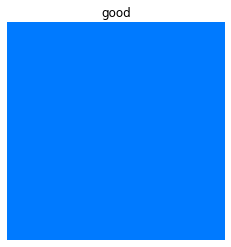

In [46]:
plot_prediction((0, 122, 255))

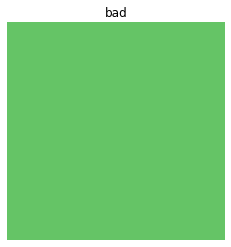

In [38]:
plot_prediction((101, 196, 102))

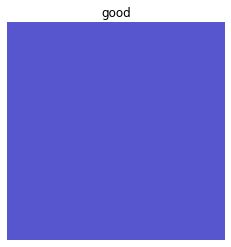

In [39]:
plot_prediction((87, 86, 207))

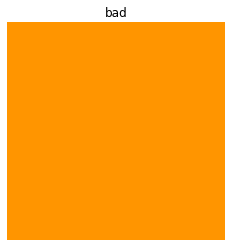

In [40]:
plot_prediction((255, 149, 0))

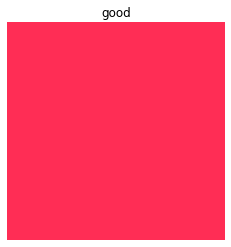

In [41]:
plot_prediction((255, 45, 85))

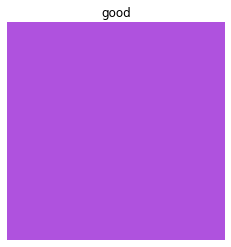

In [42]:
plot_prediction((175, 82, 222))

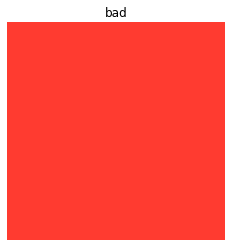

In [43]:
plot_prediction((255, 59, 48))

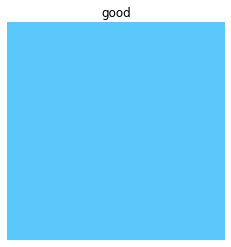

In [44]:
plot_prediction((90, 200, 250))

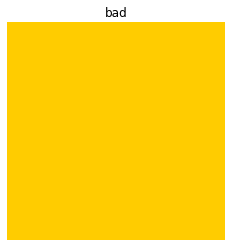

In [45]:
plot_prediction((255, 204, 0))